# Using IBM Cloud SQL Query Geospatial

Geospatial data obtained through mobile devices and IoT sensors has become ubiquitous in the past few years. This notebook is developed as a guide to showcase how SQL Query's Geospatial APIs can be used to obtain useful insights from such data. <br> The data that we will use is made available by the New York City Taxi and Limousine Commission (<a href="http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml" target="_blank" rel="noopener noreferrer">NYC Taxicab Trips Data</a>). It consists of taxicab trip pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. We will use data from the first week of December 2015 for analysis in this notebook. NYC Yellow Taxicab data for December 2015 can be downloaded from <a href="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-12.csv" target="_blank" rel="noopener noreferrer">here</a>. To get only December 2015 first week data from the downloaded file, simply run the following shell command: `grep 2015-12-0[1-7] yellow_tripdata_2015-12.csv > yellow_tripdata_2015-12_week1.csv`
<br> NYC Point of Interest data can be downloaded from <a href="https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj/data" target="_blank" rel="noopener noreferrer">here</a>.
<br> Once the two datasets are available on IBM Cloud Object Storage, they can be used with this notebook. Please provide the dataset URL's as input parameters when running cell 2.
<br> The notebook uses the <a href="https://github.com/IBM-Cloud/sql-query-clients/tree/master/Python" target="_blank" rel="noopener noreferrer">ibmcloudsql</a> Python library, along with the PixieDust library for visualization.

## Table of contents
1. [Setup and Configuration](#setup)<br>
2. [What are the Overall Top Pickup and Dropoff Locations](#query1)<br>
3. [Weekday Morning Trends](#query2)<br>
4. [Weekend Hangout Trends](#query3)<br>
5. [Which Neighborhoods Tip the Most?](#query4)<br>
6. [Most Visited POIs](#query5)<br>
7. [Airport Trends](#query6)<br>
8. [Next steps](#next)<br>

### <a name="setup"></a> 1. Setup and Configuration

Following detailed setup and configuration steps from [here](https://dataplatform.ibm.com/exchange/public/entry/view/4a9bb1c816fb1e0f31fec5d580e4e14d)

In [1]:
!conda install pyarrow
!pip install --user --upgrade ibmcloudsql
!pip install --user --upgrade sqlparse
!pip install --user --upgrade pixiedust

Fetching package metadata ...........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
pyarrow                   0.9.0            py35hfc40096_2  
Requirement already up-to-date: ibmcloudsql in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: tornado<=4.5.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmcloudsql)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmcloudsql)
Requirement not upgraded as not directly required: botocore in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmcloudsql)
Requirement not upgraded as not directly required: pyarrow in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibmcloudsql)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/p

In [2]:
import ibmcloudsql
from pixiedust.display import *
import pandas as pd
import sqlparse
from pygments import highlight
from pygments.lexers import get_lexer_by_name
from pygments.formatters import HtmlFormatter, Terminal256Formatter
targeturl=''
taxiurl=''
poiurl=''

Pixiedust database opened successfully


In [3]:
import getpass
apikey=getpass.getpass('Enter IBM Cloud API Key (leave empty to use previous one): ') or apikey
instnacecrn=input('Enter SQL Query Instance CRN (leave empty to use previous one): ') or instnacecrn
if targeturl == '':
    targeturl=input('Enter target URL for SQL results: ')
else:
    targeturl=input('Enter target URL for SQL results (leave empty to use ' + targeturl + '): ') or targeturl
if taxiurl == '':
    taxiurl=input('Enter taxicab dataset URL: ')
else:
    taxiurl=input('Enter taxicab dataset URL (leave empty to use ' + taxiurl + '): ') or taxiurl
if poiurl == '':
    poiurl=input('Enter Point of Interest dataset URL: ')
else:
    poiurl=input('Enter Point of Interest URL (leave empty to use ' + poiurl + '): ') or poiurl
sqlClient = ibmcloudsql.SQLQuery(apikey, instnacecrn, targeturl, client_info='Geospatial Taxicab Sample Notebook')
sqlClient.logon()
print('\nYour SQL Query web console link:\n')
sqlClient.sql_ui_link()

Enter IBM Cloud API Key (leave empty to use previous one): ········
Enter SQL Query Instance CRN (leave empty to use previous one): crn%3Av1%3Abluemix%3Apublic%3Asql-query%3Aus-south%3Aa%2F3ac874e10c8ca426580dc63d4462cbdd%3Ae0697288-d3f6-457f-871e-50d18258034d%3A%3A
Enter target URL for SQL results: cos://us-geo/sqltest/result/
Enter taxicab dataset URL: cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
Enter Point of Interest dataset URL: cos://us-south/sql-e0697288-d3f6-457f-871e-50d18258034d/Point_Of_Interest.csv

Your SQL Query web console link:

https://sql.ng.bluemix.net/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/3ac874e10c8ca426580dc63d4462cbdd:e0697288-d3f6-457f-871e-50d18258034d::


In [4]:
def formatSql(sql):
    formatted_sql = sqlparse.format(sql, reindent=True, indent_tabs=True, keyword_case='upper')
    lexer = get_lexer_by_name("sql", stripall=True)
    formatter = Terminal256Formatter(style='tango')
    return highlight(formatted_sql, lexer, formatter) 

### <a name="query1"></a> 2. What are the Overall Top Pickup and Dropoff Locations

We will now run a SQL query to get the top pickup and dropoff locations, and the average passenger counts, distances, fare and tip amounts for these locations. The nested sub-query first gets geohashes for all pickup and dropoff locations with a 300 meter radius buffer, through the ST_ContainingGeohash UDF. To eliminate erroneous locations, we bound the latitude and longitude values to roughly only look at locations that fall within the new york area. The results are then grouped by the geohashes, and for each group, we get average statistics for the group, such as the average passenger count, trip distance, fare amount and tip amount. In addition, for each group, the geohash's bounding box is obtained through the ST_GeohashDecode and ST_Envelope UDFs. ST_BoundingBoxCenter UDF is then used to obtain the bounding box's center point. The ST_X and ST_Y UDFs allow obtaining the center's longitude and latitude values. The results are ordered by descending geohash counts, thus getting us the 50 most popular pickup and dropoff locations

In [5]:
sql1 = """
SELECT AVG(PASSENGER_COUNT), AVG(TRIP_DISTANCE), AVG(FARE_AMOUNT), AVG(TIP_AMOUNT),ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count FROM (SELECT PASSENGER_COUNT, TRIP_DISTANCE, FARE_AMOUNT, TIP_AMOUNT,
cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300) as string) as geohash
FROM """ + taxiurl + """ WHERE PICKUP_LONGITUDE < -60 AND PICKUP_LATITUDE > 30 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND 
DROPOFF_LATITUDE != PICKUP_LATITUDE) 
GROUP BY geohash ORDER BY count DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql1))

SQL Query is :

SELECT AVG(PASSENGER_COUNT),
	AVG(TRIP_DISTANCE),
	AVG(FARE_AMOUNT),
	AVG(TIP_AMOUNT),
	ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
	count(*) AS COUNT
FROM
		(SELECT PASSENGER_COUNT,
				TRIP_DISTANCE,
				FARE_AMOUNT,
				TIP_AMOUNT,
				cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE PICKUP_LONGITUDE < -60
					AND PICKUP_LATITUDE > 30
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE)
GROUP BY geohash
ORDER BY COUNT DESC
LIMIT 50



In [6]:
top_pickup_df = sqlClient.run_sql(sql1)
if isinstance(top_pickup_df, str):
    print(top_pickup_df)

**Display the top 50 pickup locations**

In [7]:
display(top_pickup_df)

Similarly, we can get the top dropoff locations

In [8]:
sql2 = """
SELECT AVG(PASSENGER_COUNT), AVG(TRIP_DISTANCE), AVG(FARE_AMOUNT), AVG(TIP_AMOUNT), ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count FROM (SELECT PASSENGER_COUNT, TRIP_DISTANCE, FARE_AMOUNT, TIP_AMOUNT,
cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 300) as string) as geohash FROM """ + taxiurl + """ WHERE DROPOFF_LONGITUDE < -60 AND DROPOFF_LATITUDE > 30 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY count
DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql2))

SQL Query is :

SELECT AVG(PASSENGER_COUNT),
	AVG(TRIP_DISTANCE),
	AVG(FARE_AMOUNT),
	AVG(TIP_AMOUNT),
	ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
	count(*) AS COUNT
FROM
		(SELECT PASSENGER_COUNT,
				TRIP_DISTANCE,
				FARE_AMOUNT,
				TIP_AMOUNT,
				cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 300) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE DROPOFF_LONGITUDE < -60
					AND DROPOFF_LATITUDE > 30
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE)
GROUP BY geohash
ORDER BY COUNT DESC
LIMIT 50



In [9]:
top_dropoff_df = sqlClient.run_sql(sql2)
if isinstance(top_dropoff_df, str):
    print(top_dropoff_df)

**Display the top 50 dropoff locations**

In [10]:
display(top_dropoff_df)

### <a name="query2"></a> 3. Weekday Morning Trends

We next run queries to get some insights about weekday morning trends. Specifically, we get the most popular dropoff locations between the hours of 6am and 11am on weekdays in the first query and the distribution of the number of dropoffs in each hour between 6am and 11am in the second query. The structure of these queries is similar to the previous set of queries, except that we add filters to only look at data between morning hours on weekdays

In [11]:
sql3 = """select ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count
from (select cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 100) as string)
as geohash from """ + taxiurl + """ where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-04' as date)
and hour(tpep_dropoff_datetime) between 6 and 11 AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY count
DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql3))

SQL Query is :

SELECT ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
	count(*) AS COUNT
FROM
		(SELECT cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 100) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE cast(tpep_dropoff_datetime AS date) BETWEEN cast('2015-12-01' AS date) AND cast('2015-12-04' AS date)
					AND hour(tpep_dropoff_datetime) BETWEEN 6 AND 11
					AND DROPOFF_LONGITUDE < 0
					AND DROPOFF_LATITUDE > 0
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE)
GROUP BY geohash
ORDER BY COUNT DESC
LIMIT 50



In [12]:
weekday_morning_dropoffs = sqlClient.run_sql(sql3)
if isinstance(weekday_morning_dropoffs, str):
    print(weekday_morning_dropoffs)

**Display the top 50 weekday morning dropoff locations**

In [13]:
display(weekday_morning_dropoffs)

In [14]:
sql4 = """
select hour(tpep_dropoff_datetime), count(*) from """ + taxiurl + """ where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-04' as date)
and hour(tpep_dropoff_datetime) between 6 and 11 AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE group by hour(tpep_dropoff_datetime)
"""
print("SQL Query is :\n")
print(formatSql(sql4))

SQL Query is :

SELECT hour(tpep_dropoff_datetime),
	count(*)
FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
WHERE cast(tpep_dropoff_datetime AS date) BETWEEN cast('2015-12-01' AS date) AND cast('2015-12-04' AS date)
		AND hour(tpep_dropoff_datetime) BETWEEN 6 AND 11
		AND DROPOFF_LONGITUDE < 0
		AND DROPOFF_LATITUDE > 0
		AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
		AND DROPOFF_LATITUDE != PICKUP_LATITUDE
GROUP BY hour(tpep_dropoff_datetime)



In [15]:
weekday_morning_hour_histogram = sqlClient.run_sql(sql4)
if isinstance(weekday_morning_hour_histogram, str):
    print(weekday_morning_hour_histogram)

**Display distribution of weekday morning hour dropoffs**


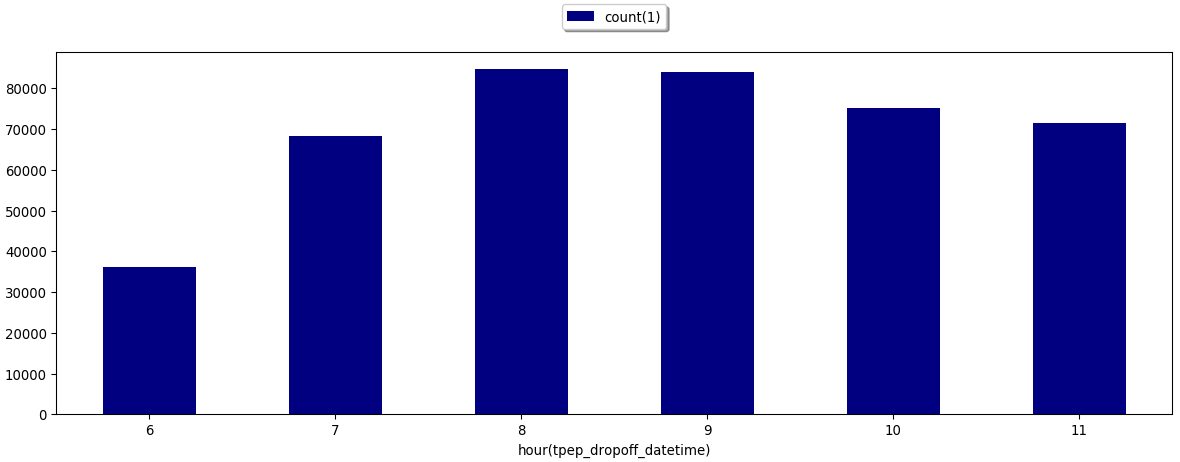

In [16]:
display(weekday_morning_hour_histogram)

### <a name="query3"></a> 4. Weekend Hangout Trends

In a similar vein, we use the pickup locations to obtain the most popular hangout spots in the city on weekend evenings in the next two queries

In [17]:
sql5 = """
select ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count
from (select cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 100) as string)
as geohash from """ + taxiurl + """ where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-05' as date) and cast('2015-12-06' as date)
and (hour(tpep_pickup_datetime) > 20 or hour(tpep_pickup_datetime) < 6) AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY count
DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql5))

SQL Query is :

SELECT ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
	count(*) AS COUNT
FROM
		(SELECT cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 100) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE cast(tpep_dropoff_datetime AS date) BETWEEN cast('2015-12-05' AS date) AND cast('2015-12-06' AS date)
					AND (hour(tpep_pickup_datetime) > 20
										OR hour(tpep_pickup_datetime) < 6)
					AND PICKUP_LONGITUDE < 0
					AND PICKUP_LATITUDE > 0
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE)
GROUP BY geohash
ORDER BY COUNT DESC
LIMIT 50



In [18]:
popular_weekend_spots = sqlClient.run_sql(sql5)
if isinstance(popular_weekend_spots, str):
    print(popular_weekend_spots)

**Display top 50 weekend evening hangout spots**

In [19]:
display(popular_weekend_spots)

In [20]:
sql6 = """
select hour(tpep_pickup_datetime), count(*) from """ + taxiurl + """ where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-05' as date) and cast('2015-12-06' as date)
and (hour(tpep_pickup_datetime) > 20 or hour(tpep_pickup_datetime) < 6) AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE group by hour(tpep_pickup_datetime)
"""
print("SQL Query is :\n")
print(formatSql(sql6))

SQL Query is :

SELECT hour(tpep_pickup_datetime),
	count(*)
FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
WHERE cast(tpep_dropoff_datetime AS date) BETWEEN cast('2015-12-05' AS date) AND cast('2015-12-06' AS date)
		AND (hour(tpep_pickup_datetime) > 20
							OR hour(tpep_pickup_datetime) < 6)
		AND PICKUP_LONGITUDE < 0
		AND PICKUP_LATITUDE > 0
		AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
		AND DROPOFF_LATITUDE != PICKUP_LATITUDE
GROUP BY hour(tpep_pickup_datetime)



In [21]:
weekend_night_hour_histogram = sqlClient.run_sql(sql6)
if isinstance(weekend_night_hour_histogram, str):
    print(weekend_night_hour_histogram)

**Display the distribution of weekend night hours when people head home**


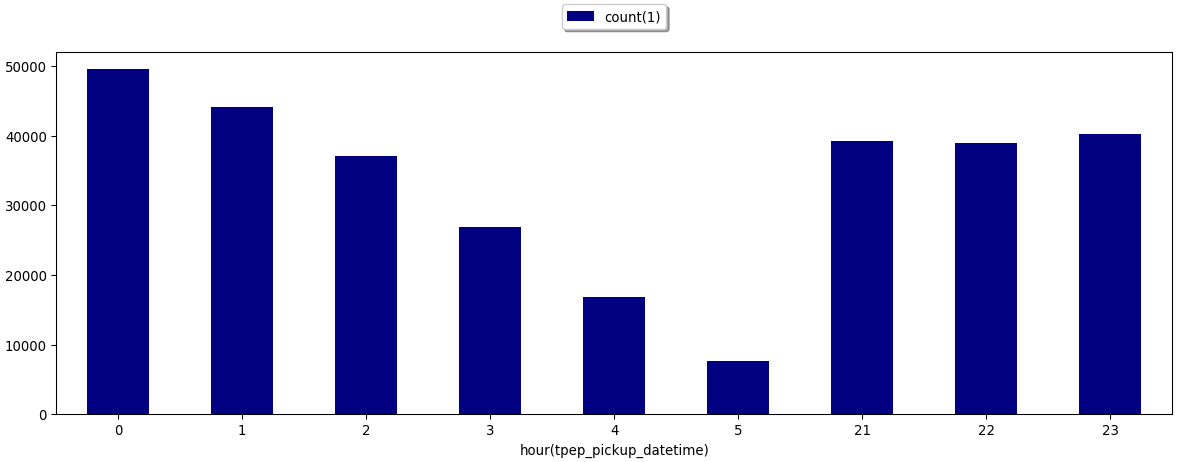

In [22]:
display(weekend_night_hour_histogram)

### <a name="query4"></a> 5. Which Neighborhoods Tip the Most?

Next, we look at average tip amounts when dropoff locations are grouped together (considered as a neighborhood) and get the neighborhoods that have the highest average tip amounts

In [23]:
sql7 = """
SELECT AVG(TIP_AMOUNT), ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count FROM (SELECT PASSENGER_COUNT, TRIP_DISTANCE, FARE_AMOUNT, TIP_AMOUNT,
cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 0) as string) as geohash FROM """ + taxiurl + """ WHERE DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND 
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY AVG(TIP_AMOUNT)
DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql7))

SQL Query is :

SELECT AVG(TIP_AMOUNT),
	ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
	count(*) AS COUNT
FROM
		(SELECT PASSENGER_COUNT,
				TRIP_DISTANCE,
				FARE_AMOUNT,
				TIP_AMOUNT,
				cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 0) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE DROPOFF_LONGITUDE < 0
					AND DROPOFF_LATITUDE > 0
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE)
GROUP BY geohash
ORDER BY AVG(TIP_AMOUNT) DESC
LIMIT 50



In [24]:
top_tip_neighborhoods = sqlClient.run_sql(sql7)
if isinstance(top_tip_neighborhoods, str):
    print(top_tip_neighborhoods)

**Display the top 50 highest tipping neighborhoods**

In [25]:
display(top_tip_neighborhoods)

### <a name="query5"></a> 6. Most Visited POIs

In this section, we look at all trips originating from the Grand Central Terminal (GCT) in NYC and and join the dropoff locations of these trips with popular Points of Interest in NYC to get an idea of where people that are visiting NYC from out of town might go. We first use the ST_Contains UDF to obtain only trips originating within the polygon representing GCT. We then use the ST_ContainingGeohash UDF to obtain geohashes for all dropoff locations for trips from GCT as well as the point of interests. Both sets of geohashes encapsulate a 10 meter radius distance for the location. Both sets of data are then joined using the geohash and grouped by the point of interest name and sorted in descending values of counts for each group, thus getting us the most popular locations visited from GCT

In [26]:
sql8 = """
select NAME from (select NAME,cast(ST_ContainingGeohash(ST_WKTToSQL(THE_GEOM),10) as string) as hash1
from """ + poiurl + """ ) as geohash1,
(select cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE,DROPOFF_LATITUDE),10) as string) as hash2
from """ + taxiurl + """,(SELECT ST_WKTToSQL('POLYGON((-73.9741470452658 40.754053521967954,-73.9775158997885 40.75528885933616,-73.9796402093283 40.75228174804338,-73.97974749768889 40.752167962783425,-73.97659321988738 40.75078626908878,-73.9741470452658 40.754053521967954))') as GCT) WHERE PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0
AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE AND
ST_Contains(GCT, ST_POINT(PICKUP_LONGITUDE, PICKUP_LATITUDE))) as geohash2
where geohash1.hash1=geohash2.hash2 group by name order by count(*) DESC LIMIT 50
"""
print("SQL Query is :\n")
print(formatSql(sql8))

SQL Query is :

SELECT NAME
FROM
		(SELECT NAME,
				cast(ST_ContainingGeohash(ST_WKTToSQL(THE_GEOM),10) AS string) AS hash1
			FROM cos://us-south/SQL-e0697288-d3f6-457f-871e-50d18258034d/Point_Of_Interest.csv) AS geohash1,

		(SELECT cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE,DROPOFF_LATITUDE),10) AS string) AS hash2
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv,
					(SELECT ST_WKTToSQL('POLYGON((-73.9741470452658 40.754053521967954,-73.9775158997885 40.75528885933616,-73.9796402093283 40.75228174804338,-73.97974749768889 40.752167962783425,-73.97659321988738 40.75078626908878,-73.9741470452658 40.754053521967954))') AS GCT)
			WHERE PICKUP_LONGITUDE < 0
					AND PICKUP_LATITUDE > 0
					AND DROPOFF_LONGITUDE < 0
					AND DROPOFF_LATITUDE > 0
					AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE
					AND DROPOFF_LATITUDE != PICKUP_LATITUDE
					AND ST_Contains(GCT, ST_POINT(PICKUP_LONGITUDE, PICKUP_LATITUDE))) AS geohash2
WHERE geohash1.hash1=geohash2.hash2

In [27]:
top_visited_from_gct = sqlClient.run_sql(sql8)
if isinstance(top_visited_from_gct, str):
    print(top_visited_from_gct)

In [28]:
print(top_visited_from_gct)

                                             NAME
0                            W HOTEL TIMES SQUARE
1              ROCKEFELLER CENTER LOWER CONCOURSE
2                                IMPERIAL THEATRE
3   THE CITIGROUP CHILDRENS CENTER AT 399 PARK AV
4                               TKTS TIMES SQUARE
5                         RED STAIRS TIMES SQUARE
6                              ROCKEFELLER CENTER
7                           AL HIRSCHFELD THEATRE
8                           LUNT FONTANNE THEATRE
9                              ART AND DESIGN H S
10                           BERKSHIRE PLACE HOTL
11                LAGUARDIA CENTRAL TERMINAL BLDG
12                               CANADA CONSULATE
13                                   TBPD DIST 01
14                            RICHARD TUCKER PARK
15                               ANSONIA BUILDING
16                           NOREL AMUSEMENT CORP
17                                 WOODWARD HOTEL
18                      MUSEUM OF ARTS AND DESIGN


### <a name="query6"></a> 7. Airport Trends

Finally, through the next two queries, we get an idea of the average trip times to JFK Airport in NYC from various neighborhoods (query 1) and during various times in the day (query 2)

In [36]:
sql9 = """
select AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 as trip_time,
ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat FROM
(SELECT tpep_pickup_datetime, tpep_dropoff_datetime, cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300) as string) as geohash FROM """ + taxiurl + """,(SELECT ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656))') as JFK)
 WHERE 
ST_Contains(JFK, ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE))
AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY trip_time DESC
"""
print("SQL Query is :\n")
print(formatSql(sql9))

SQL Query is :

SELECT AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 AS trip_time,
	ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
	ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat
FROM
		(SELECT tpep_pickup_datetime,
				tpep_dropoff_datetime,
				cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300) AS string) AS geohash
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv,
					(SELECT ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656

In [37]:
jfk_trip_times = sqlClient.run_sql(sql9)
if isinstance(jfk_trip_times, str):
    print(jfk_trip_times)

**Display the average trip times to JFK from various NYC neighborhoods**

In [38]:
display(jfk_trip_times)

In [32]:
sql10 = """
select hour(tpep_dropoff_datetime), AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 as trip_time
FROM (SELECT tpep_pickup_datetime, tpep_dropoff_datetime FROM """ + taxiurl + """,(SELECT ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656))') as JFK)
 WHERE ST_Contains(JFK, ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE)))
GROUP BY hour(tpep_dropoff_datetime) ORDER BY trip_time DESC
"""
print("SQL Query is :\n")
print(formatSql(sql10))

SQL Query is :

SELECT hour(tpep_dropoff_datetime),
	AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 AS trip_time
FROM
		(SELECT tpep_pickup_datetime,
				tpep_dropoff_datetime
			FROM cos://us-geo/benchmarktest/yellow_tripdata_2015-12_week1.csv
			WHERE ST_Contains(ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656))'), ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE)))
GROUP BY hour(tpep_dropoff_datetime)
ORDER BY trip_time DESC



In [33]:
jfk_trip_times_by_hour = sqlClient.run_sql(sql10)
if isinstance(jfk_trip_times_by_hour, str):
    print(jfk_trip_times_by_hour)

**Display the average trip times to JFK during each hour in a day**


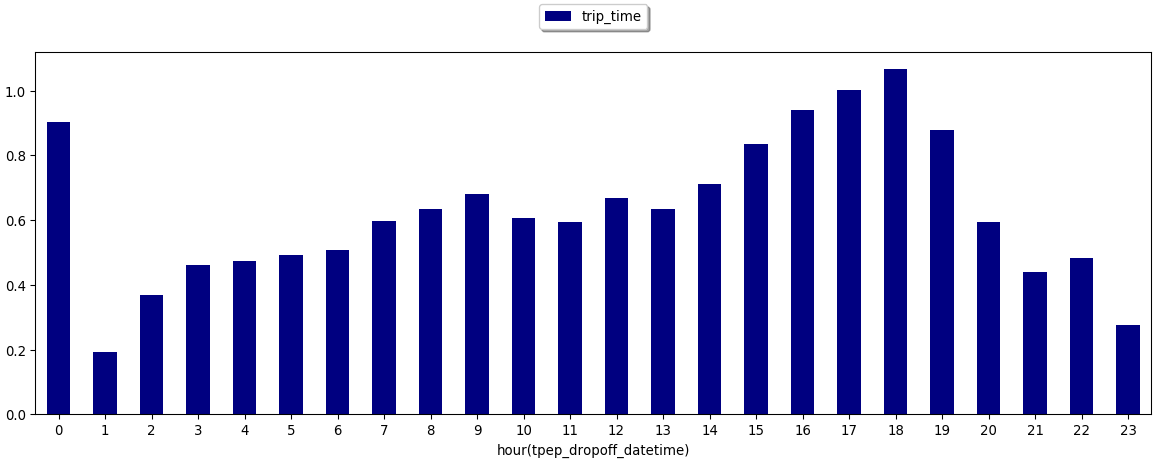

In [34]:
display(jfk_trip_times_by_hour)

### <a name="next"></a> 8. Next Steps

In this notebook, we used SQL query's geospatial capabilities to obtain interesting insights from NYC taxi trips data. A list of all available geospatial operations in SQL query can be found here : https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/geo_functions.html